In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import sklearn as sk
import scipy as sp
import matplotlib as pl
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import LatentDirichletAllocation
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree, ward
import re

# 1. Read and clean the data

In [2]:
data = pd.read_csv('Combined_News_DJIA2.csv')

print(data.shape)

from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
for i in range (data.shape[0]):
    for j in range (1,data.shape[1]):
        temp=data.iloc[i,j]
        if type(temp)!=str:
            continue
        if temp[0]=='b':
            temp=re.sub('[^A-Za-z0-9]+', ' ', temp[2:-1])
        else:
            temp=re.sub('[^A-Za-z0-9]+', ' ', temp)
        data.iloc[i,j]=" ".join([stemmer.stem(k) for k in temp.split()])

(1984, 27)


In [3]:
data["Date"] = pd.to_datetime(data["Date"])
train = data[data['Date'] < '2015-01-01']
test = data[data['Date'] > '2014-12-31']

## Word Counts: CountVectorizer

In [4]:
cv_object = CountVectorizer(token_pattern = '[a-zA-Z]{2,}', 
                            lowercase = True, 
                            stop_words = 'english', 
                            ngram_range = (2,4)
                           )  # do we need to use a N-gram model?

# train set
# build a "single list of strings"
trainheadlines = []
for row in range(0,len(train.index)):
    trainheadlines.append(' '.join(str(x) for x in train.iloc[row,2:27]))
train_mat = cv_object.fit_transform(trainheadlines)

# test set
testheadlines = []
for row in range(0,len(test.index)):
    testheadlines.append(' '.join(str(x) for x in test.iloc[row,2:27]))
test_mat = cv_object.transform(testheadlines)

In [5]:
# summary
# dimensions
print(train_mat.shape)
print(test_mat.shape)

# top 30 words
print(cv_object.get_feature_names()[:30])
# no more stemming words

(1606, 1168031)
(378, 1168031)
['aa pakistan', 'aa pakistan acquit', 'aa pakistan acquit girl', 'aaa credit', 'aaa credit rate', 'aaa credit rate australia', 'aaa credit rate happen', 'aaa credit rate moodi', 'aaa rate', 'aaa rate assign', 'aaa rate assign toxic', 'aaa rate ireland', 'aaa rate ireland surviv', 'aaa rate polish', 'aaa rate polish soldier', 'aaa seal', 'aaa seal approv', 'aaa seal approv worthless', 'aaaw nice', 'aaaw nice stori', 'aaaw nice stori white', 'aabo abl', 'aabo abl feel', 'aabo abl feel hand', 'aadmi parti', 'aadmi parti aap', 'aadmi parti aap parti', 'aafia disappear', 'aafia disappear children', 'aafia disappear children visit']


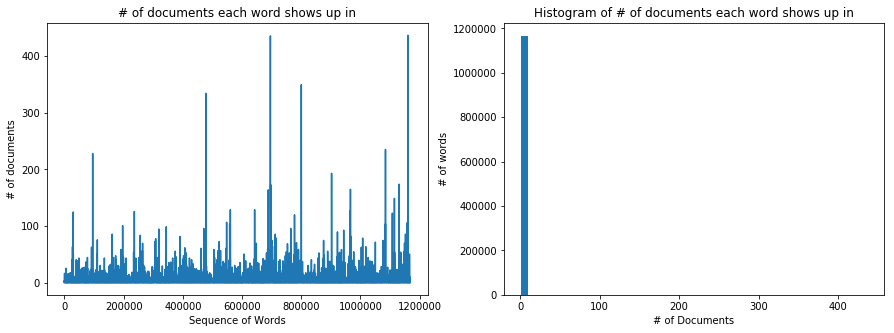

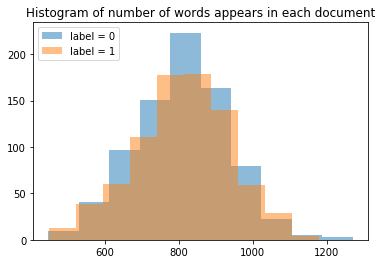

[1160092]
The word 'year old' appears in most documents.


In [6]:
freqs = sp.sparse.coo_matrix.sum(train_mat>0, axis = 0)
freqs = np.array(freqs.tolist()[0])

fig, axs = plt.subplots(1, 2, figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(freqs)
plt.title('# of documents each word shows up in')
plt.xlabel('Sequence of Words')
plt.ylabel('# of documents')

# hist
plt.subplot(1,2,2)
plt.hist(freqs, bins = 50)
plt.title('Histogram of # of documents each word shows up in')
plt.xlabel('# of Documents')
plt.ylabel('# of words')
plt.show()
  
num_words = sp.sparse.coo_matrix.sum(train_mat>0, axis = 1)
num_words = np.array(num_words.flatten())[0]
idx = (train['Label']==0)
#bins = np.linspace(120, 450, 40)
plt.hist(num_words[idx], alpha = 0.5, label = 'label = 0')
plt.hist(num_words[~idx],  alpha = 0.5, label = 'label = 1')
plt.legend(loc="upper left")
plt.title("Histogram of number of words appears in each document")
plt.show()

idx = np.argwhere(freqs == np.max(freqs)).flatten()
words = cv_object.get_feature_names()
print(idx)
for i in idx:
    print("The word '%s' appears in most documents." % (words[i]))

In [7]:
# logistic model
lm = LogisticRegression()
lm.fit(train_mat, train["Label"])

test_yhat = lm.predict(test_mat)

In [8]:
# confusion matrix
confusion = pd.crosstab(test["Label"], test_yhat, rownames=["Actual"], colnames=["Predicted"])
print(confusion)

# misclassification rate
mis = np.mean(test_yhat != test["Label"])
print(mis)

Predicted   0    1
Actual            
0          60  118
1          75  125
0.5105820105820106


## Word Frequency: TfidVectorizer

In [9]:
tfid = TfidfTransformer(use_idf=True)
train_mat2 = tfid.fit_transform(train_mat)
test_mat2 = tfid.transform(test_mat)

In [10]:
# logistic model
lm = LogisticRegression()
lm.fit(train_mat2, train["Label"])

test_yhat = lm.predict(test_mat2)

# confusion matrix
confusion = pd.crosstab(test["Label"], test_yhat, rownames=["Actual"], colnames=["Predicted"])
print(confusion)

# misclassification rate
mis = np.mean(test_yhat != test["Label"])
print(mis)

Predicted   0    1
Actual            
0          33  145
1          39  161
0.48677248677248675


# LDA

In [11]:
lda = LatentDirichletAllocation(n_components = 2, learning_method='batch', max_iter=100)
fit = lda.fit_transform(train_mat)   # theta, proportions of each topic in the dth document
topics = lda.components_/lda.components_.sum(axis=1)[:, np.newaxis]  # beta, distributions over words for each topic

In [12]:
print("Top 20 words for label 0")
idx = topics[0].argsort()[-20:][::-1]
words = np.array(words)
print(words[idx])

idx = topics[1].argsort()[-20:][::-1]
print("Top 20 words for label 1")
print(words[idx])

Top 20 words for label 0
['north korea' 'year old' 'human right' 'prime minist' 'unit state'
 'bbc news' 'saudi arabia' 'west bank' 'julian assang' 'new zealand'
 'war crime' 'south korea' 'north korean' 'al jazeera' 'edward snowden'
 'middl east' 'al qaeda' 'kim jong' 'islam state' 'vladimir putin']
Top 20 words for label 1
['north korea' 'year old' 'prime minist' 'human right' 'bbc news'
 'north korean' 'unit state' 'new zealand' 'south korea' 'saudi arabia'
 'west bank' 'war crime' 'kim jong' 'pirat bay' 'middl east' 'al qaeda'
 'hong kong' 'south africa' 'court rule' 'polic offic']


In [13]:
from sklearn.metrics import confusion_matrix

topic_prob = fit[:,0]
idx = sum(train['Label']==0)

y = (train['Label']==0)*1
y_hat = (topic_prob > 0.5)*1
print("Confusion matrix:")
print(confusion_matrix(y, y_hat))
mis = np.mean(y!=y_hat)
print("Train Misclassification rate:", mis)

Confusion matrix:
[[403 409]
 [378 416]]
Train Misclassification rate: 0.4900373599003736


In [14]:
testfit = lda.transform(test_mat)
y_test = (test['Label']==0)*1
topic_prob = testfit[:,0]
y_hat = (topic_prob>0.5)*1
print("Test Confusion matrix:")
print(confusion_matrix(y_test, y_hat))
mis = np.mean(y_test!=y_hat)
print("Test Misclassification rate:", mis)

Test Confusion matrix:
[[ 84 116]
 [ 75 103]]
Test Misclassification rate: 0.5052910052910053


AUC:  0.47587078651685394


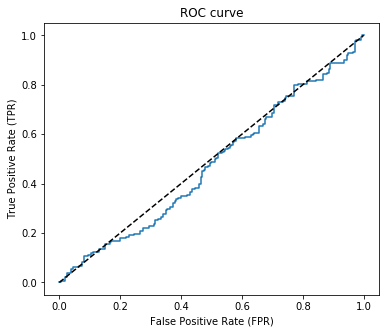

In [15]:
# ROC and AUC
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test, topic_prob)
fig, ax = plt.subplots(figsize = (6,5))
# area under curve
roc_auc = sk.metrics.auc(fpr, tpr)

ax.plot(fpr, tpr)
ax.plot([0,1],[0,1],"k--")
ax.set(xlabel = "False Positive Rate (FPR)",
       ylabel = "True Positive Rate (TPR)",
       title = "ROC curve")
print("AUC: ",roc_auc)

In [16]:
# top 100
test_prob = testfit[:,0]
top100_id = np.argsort(test_prob)[::-1][:100]

rf_success_in_top_100 = np.mean(np.array(y_test)[top100_id])
print("fraction of Yes: ",rf_success_in_top_100)
print("base rate: ", np.mean(y_test))

fraction of Yes:  0.41
base rate:  0.4708994708994709


### after using TfidVectorizer

In [17]:
# after using TfidVectorizer
lda2 = LatentDirichletAllocation(n_components = 2, learning_method='batch', max_iter=100)
fit2 = lda2.fit_transform(train_mat2)   # theta, proportions of each topic in the dth document
topics2 = lda2.components_/lda2.components_.sum(axis=1)[:, np.newaxis]  # beta, distributions over words for each topic

In [18]:
print("Top 20 words for label 0")
idx = topics2[0].argsort()[-20:][::-1]
words = np.array(words)
print(words[idx])

idx = topics2[1].argsort()[-20:][::-1]
print("Top 20 words for label 1")
print(words[idx])

Top 20 words for label 0
['north korea' 'year old' 'human right' 'prime minist' 'bbc news'
 'unit state' 'saudi arabia' 'kim jong' 'west bank' 'new zealand'
 'north korean' 'war crime' 'al jazeera' 'south korea' 'middl east'
 'julian assang' 'bin laden' 'edward snowden' 'al qaeda' 'south africa']
Top 20 words for label 1
['north korea' 'year old' 'prime minist' 'human right' 'saudi arabia'
 'south korea' 'north korean' 'new zealand' 'unit state' 'bbc news'
 'west bank' 'julian assang' 'war crime' 'islam state' 'hong kong'
 'edward snowden' 'middl east' 'al qaeda' 'climat chang' 'polic offic']


Train Confusion matrix:
[[402 410]
 [375 419]]
Train Misclassification rate: 0.4887920298879203
Test Confusion matrix:
[[ 71 129]
 [ 67 111]]
Test Misclassification rate: 0.5185185185185185
AUC:  0.49143258426966296


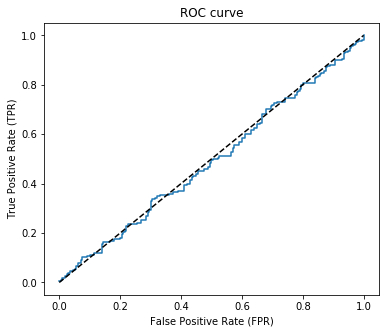

In [19]:
topic_prob2 = fit2[:,0]
idx = sum(train['Label']==0)

y = (train['Label']==0)*1
y_hat = (topic_prob2 > 0.5)*1
print("Train Confusion matrix:")
print(confusion_matrix(y, y_hat))
mis = np.mean(y!=y_hat)
print("Train Misclassification rate:", mis)

testfit = lda2.transform(test_mat)
y_test = (test['Label']==0)*1
topic_prob = testfit[:,0]
y_hat = (topic_prob>0.5)*1
print("Test Confusion matrix:")
print(confusion_matrix(y_test, y_hat))
mis = np.mean(y_test!=y_hat)
print("Test Misclassification rate:", mis)

# ROC and AUC
fpr, tpr, _ = roc_curve(y_test, topic_prob)
fig, ax = plt.subplots(figsize = (6,5))
# area under curve
roc_auc = sk.metrics.auc(fpr, tpr)

ax.plot(fpr, tpr)
ax.plot([0,1],[0,1],"k--")
ax.set(xlabel = "False Positive Rate (FPR)",
       ylabel = "True Positive Rate (TPR)",
       title = "ROC curve")
print("AUC: ",roc_auc)

LDA models did not perform well. 

# Clustering

In [20]:
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics.pairwise import euclidean_distances
from scipy.spatial.distance import squareform

In [21]:
X = train_mat

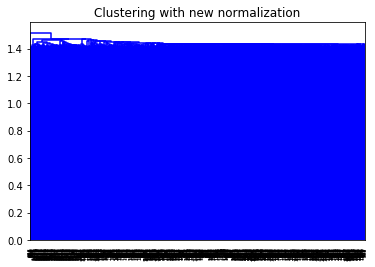

Misclassification rate: 0.5049813200498132


In [22]:
tfid = TfidfTransformer(use_idf=True)
X4 = tfid.fit_transform(X)
dist = euclidean_distances(X4)
dist = (dist + dist.T)/2
dist = squareform(dist)
clust = ward(dist)
dn = dendrogram(clust)
plt.title("Clustering with new normalization")
plt.show()
cutree = cut_tree(clust, n_clusters=2)
yhat = 1-cutree.flatten()
pd.crosstab(y, yhat)
mis = np.mean(y!=yhat)
print("Misclassification rate:", mis)

In [23]:
vix = pd.read_csv("vix.csv")

In [24]:
vix = vix.iloc[:,0]

In [25]:
test_vix = vix.iloc[-test.shape[0]:]

In [32]:
cutree = cut_tree(clust, n_clusters=50)
yhat = cutree.flatten()
test['Date'].shape
print(test_vix.shape)
print(yhat.shape)

(378,)
(1606,)


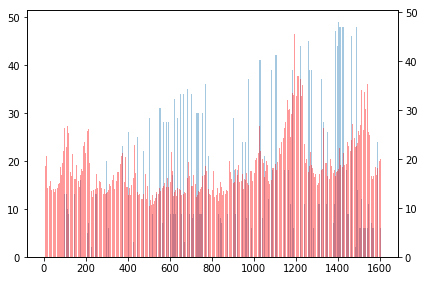

In [33]:
fig, ax1 = plt.subplots()
ax1.bar(x = np.arange(yhat.shape[0]), height = yhat, alpha = 0.4)
ax2 = ax1.twinx()
ax2.bar(x = np.arange(yhat.shape[0]), height = vix[:yhat.shape[0]], color = "red", alpha = 0.4)
fig.tight_layout()
plt.show()